In [1]:
!pip install -U giotto-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not cur

# Predicción de series Temporales de Temperatura utilizando análisis Topológico de datos
#####El objetivo es aplicar análisis Topológico de datos para la predicción de series de tiempo de temperatura. Se utiliza Giotto-TDA para trabajar con topología y colección de conjuntos de datos de temperatura.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from gtda.diagrams import PersistenceLandscape
from gtda.diagrams import Silhouette

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'gtda'

In [ ]:
def extract_topological_features(series, window_size=30, stride=1,
                                embedding_dim=3, embedding_delay=1,
                                forecast_horizon=1, verbose=False):
    """
    Extrae características topológicas usando Persistence Landscapes.
    """

    windows = []
    window_end_indices = []

    for i in range(0, len(series) - window_size - forecast_horizon + 1, stride):
        windows.append(series[i:i + window_size])
        window_end_indices.append(i + window_size)

    if len(windows) == 0:
        raise ValueError(f"No hay suficientes datos. Serie: {len(series)}, Ventana: {window_size}")

    windows = np.array(windows)

    # Crear nubes de puntos con Takens embedding
    point_clouds = []
    n_points_list = []

    for window in windows:
        n_points = len(window) - (embedding_dim - 1) * embedding_delay
        if n_points > 0:
            embedded_points = np.zeros((n_points, embedding_dim))
            for i in range(n_points):
                for j in range(embedding_dim):
                    embedded_points[i, j] = window[i + j * embedding_delay]
            point_clouds.append(embedded_points)
            n_points_list.append(n_points)
        else:
            embedded_points = np.array([[window[0]] * embedding_dim])
            point_clouds.append(embedded_points)
            n_points_list.append(1)

    max_points = max(n_points_list)
    point_clouds_padded = []

    for pc in point_clouds:
        if pc.shape[0] < max_points:
            padding = np.full((max_points - pc.shape[0], embedding_dim), np.nan)
            pc_padded = np.vstack([pc, padding])
        else:
            pc_padded = pc
        point_clouds_padded.append(pc_padded)

    point_clouds_uniform = np.array(point_clouds_padded)

    # Calcular homología persistente
    persistence = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=[0, 1],
        n_jobs=-1
    )
    diagrams = persistence.fit_transform(point_clouds_uniform)

    # Extraer características usando Persistence Landscapes 
    features_list = []

    # Persistence Landscapes
    landscape = PersistenceLandscape()
    landscape_features = landscape.fit_transform(diagrams)
    landscape_features_flat = landscape_features.reshape(
        landscape_features.shape[0], -1
    )
    features_list.append(landscape_features_flat)

    # Persistence Silhouettes
    #silhouette = Silhouette()
    #silhouette_features = silhouette.fit_transform(diagrams)
    #silhouette_features_flat = silhouette_features.reshape(
     #   silhouette_features.shape[0], -1
    #)
    #features_list.append(silhouette_features_flat)

    all_features = np.hstack(features_list)

    if verbose:
        print(f"  Ventanas: {len(windows)}, Características: {all_features.shape}")
        print(f"  Nubes de puntos: {point_clouds_uniform.shape}")

    return all_features, window_end_indices


def completar_series_con_fechas(temp_file, lluvia_file, fecha_inicio='1979-07-04', fecha_fin='2023-12-24'):
    """
    Detectar fechas faltantes y rellena con interpolación, aunque no es la mejor opción. 
    """

    fecha_inicio = pd.to_datetime(fecha_inicio)
    fecha_fin = pd.to_datetime(fecha_fin)
    rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

    if 'fecha' in temp_file.columns:
        temp_file['fecha'] = pd.to_datetime(temp_file['fecha'])
        temp_file['tmed_clean'] = pd.to_numeric(temp_file['tmed'], errors='coerce')
        df_temp = temp_file[['fecha', 'tmed_clean']].set_index('fecha')
    else:
        temp_vals = pd.to_numeric(temp_file['tmed'], errors='coerce').values
        fechas_temp = [fecha_inicio + timedelta(days=i) for i in range(len(temp_vals))]
        df_temp = pd.DataFrame({
            'tmed_clean': temp_vals
        }, index=fechas_temp)

    if 'fecha' in lluvia_file.columns:
        lluvia_file['fecha'] = pd.to_datetime(lluvia_file['fecha'])
        lluvia_file['pcpn_clean'] = pd.to_numeric(lluvia_file['pcpn'], errors='coerce')
        df_lluvia = lluvia_file[['fecha', 'pcpn_clean']].set_index('fecha')
    else:
        lluvia_vals = pd.to_numeric(lluvia_file['pcpn'], errors='coerce').values
        fechas_lluvia = [fecha_inicio + timedelta(days=i) for i in range(len(lluvia_vals))]
        df_lluvia = pd.DataFrame({
            'pcpn_clean': lluvia_vals
        }, index=fechas_lluvia)


    df_temp_completo = df_temp.reindex(rango_completo)
    df_lluvia_completo = df_lluvia.reindex(rango_completo)

    fechas_faltantes_temp = df_temp_completo['tmed_clean'].isna().sum()
    fechas_faltantes_lluvia = df_lluvia_completo['pcpn_clean'].isna().sum()


    # Mostrar algunas fechas faltantes específicas
    if fechas_faltantes_temp > 0:
        faltantes_temp = df_temp_completo[df_temp_completo['tmed_clean'].isna()].index
        print(f"   Ejemplo fechas faltantes temp: {faltantes_temp[:5].tolist()}")

    if fechas_faltantes_lluvia > 0:
        faltantes_lluvia = df_lluvia_completo[df_lluvia_completo['pcpn_clean'].isna()].index
        print(f"   Ejemplo fechas faltantes lluvia: {faltantes_lluvia[:5].tolist()}")

    # Interpolar valores faltantes
    df_temp_completo['tmed_clean'] = df_temp_completo['tmed_clean'].interpolate(
        method='linear',
        limit_direction='both'
    )

    df_lluvia_completo['pcpn_clean'] = df_lluvia_completo['pcpn_clean'].interpolate(
        method='linear',
        limit_direction='both'
    )

    if df_temp_completo['tmed_clean'].isna().sum() > 0:
        media_temp = df_temp_completo['tmed_clean'].mean()
        df_temp_completo['tmed_clean'] = df_temp_completo['tmed_clean'].fillna(media_temp)
        print(f" Temperatura: {df_temp_completo['tmed_clean'].isna().sum()} NaN restantes llenados con media")

    if df_lluvia_completo['pcpn_clean'].isna().sum() > 0:
        media_lluvia = df_lluvia_completo['pcpn_clean'].mean()
        df_lluvia_completo['pcpn_clean'] = df_lluvia_completo['pcpn_clean'].fillna(media_lluvia)
        print(f"  Lluvia: {df_lluvia_completo['pcpn_clean'].isna().sum()} NaN restantes llenados con media")

    return (df_temp_completo['tmed_clean'].values,
            df_lluvia_completo['pcpn_clean'].values,
            df_temp_completo.index.values)

In [ ]:
temp_file = pd.read_excel('/content/drive/MyDrive/Proyectos/tmed_serie1979_2023.xlsx')
#temp_data_raw = pd.to_numeric(temp_file['tmed'], errors='coerce').interpolate(method='linear').to_numpy()

# Cargar lluvia
lluvia_file = pd.read_excel('/content/drive/MyDrive/Proyectos/pcpn_serie1979_2023.xlsx')
#lluvia_data_raw = pd.to_numeric(lluvia_file['pcpn'], errors='coerce').interpolate(method='linear').to_numpy()
fecha_inicio = '1979-07-04'

temp_data, lluvia_data, fechas = completar_series_con_fechas(temp_file, lluvia_file)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(fechas, temp_data, markersize=3, linewidth=1, label='Temperatura')
ax1.set_title('Temperatura')
ax1.set_ylabel('°C')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(fechas, lluvia_data, markersize=3, linewidth=1, label='Lluvia')
ax2.set_title('Lluvia')
ax2.set_ylabel('mm')
ax2.set_xlabel('Fecha')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def particion_data(temperature, lluvia, fechas, años_validacion=2):
    """
    Partición temporal usando:
      - TRAIN: todo antes del bloque final de 2 años
      - VAL: los últimos 2 años exactos
    """

    fechas = pd.to_datetime(fechas)

    fecha_final = fechas[-1]

    fecha_inicio_val = fecha_final - pd.DateOffset(years=años_validacion)

    idx_val_start = np.where(fechas >= fecha_inicio_val)[0][0]

    temp_train = temperature[:idx_val_start]
    temp_val   = temperature[idx_val_start:]

    lluvia_train = lluvia[:idx_val_start]
    lluvia_val   = lluvia[idx_val_start:]

    fechas_train = fechas[:idx_val_start]
    fechas_val   = fechas[idx_val_start:]

    return (temp_train, temp_val,
            lluvia_train, lluvia_val,
            fechas_train, fechas_val)

(temp_train, temp_val,
 lluvia_train, lluvia_val,
 fechas_train, fechas_val) = particion_data(
    temp_data, lluvia_data, fechas, años_validacion=2
)

In [ ]:
def extraer_caracteristicas_por_particion(lluvia_series, temp_series, window_size=30,
                                        forecast_horizon=7, verbose=True, vari=0.95):
    """
    Extraer características topológicas de lluvia para predecir temperatura
    """
    if verbose:
        print(f" Extrayendo características - Ventana: {window_size}, Horizonte: {forecast_horizon}")

    features, feature_indices = extract_topological_features(
        lluvia_series,
        window_size=window_size,
        forecast_horizon=forecast_horizon,
        verbose=False
    )
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=vari) 
    features_pca = pca.fit_transform(features_scaled)

    targets = temp_series[feature_indices]

    if verbose:
        print(f"   Características: {features.shape}")
        print(f"   Targets: {targets.shape}")
        print(f"   Rango índices: {feature_indices[0]} a {feature_indices[-1]}")

    return features_pca, targets, feature_indices

In [ ]:
X_train_scaled, y_train, idx_train = extraer_caracteristicas_por_particion(
    lluvia_train, temp_train,
    forecast_horizon=1,
    verbose=False, vari=0.88
)

X_val_scaled, y_val, idx_val = extraer_caracteristicas_por_particion(
    lluvia_val, temp_val,
    forecast_horizon=1,
    verbose=False
)

# Escalador para exógenas
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)

In [ ]:
X_train_scaled[0]

In [ ]:
order = (3,1,2)

preds_arimax = []

for t in range(len(y_val)):
    y_until_t = np.concatenate([y_train, y_val[:t]])
    X_until_t = np.concatenate([X_train_scaled, X_val_scaled[:t]])

    model_ = ARIMA(y_until_t, exog=X_until_t, order=order).fit()
    pred = model_.forecast(steps=1, exog=X_val_scaled[t:t+1])[0]
    preds_arimax.append(pred)
    if t % 10 == 0:
        print(t)

mae_arimax = mean_absolute_error(y_val, preds_arimax)
rmse_arimax = np.sqrt(mean_squared_error(y_val, preds_arimax))

In [ ]:
preds_arima = []

for t in range(len(y_val)):
    y_until_t = np.concatenate([y_train, y_val[:t]])  
    model_ = ARIMA(y_until_t, order=order).fit()
    pred = model_.forecast()[0]
    preds_arima.append(pred)
    if t % 10 == 0:
        print(t)
mae_arima = mean_absolute_error(y_val, preds_arima)
rmse_arima = np.sqrt(mean_squared_error(y_val, preds_arima))

metricas = pd.DataFrame({
    "Modelo": ["ARIMA", "ARIMAX"],
    "MAE": [mae_arima, mae_arimax],
    "RMSE": [rmse_arima, rmse_arimax]
})

print(metricas)

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_val, label="Real")
plt.plot(preds_arima, label="ARIMA")
plt.plot(preds_arimax, label="ARIMAX")
plt.legend()
plt.title("Prediction")
plt.show()


errores_arima = np.abs(y_val - np.array(preds_arima))
errores_arimax = np.abs(y_val - np.array(preds_arimax))

plt.figure(figsize=(14,5))
plt.plot(errores_arima, label="Error ARIMA")
plt.plot(errores_arimax, label="Error ARIMAX")
plt.title("Errores")
plt.xlabel("Tiempo")
plt.ylabel("Error absoluto")
plt.legend()
plt.show()



##Nube de Puntos y Embebimiento Takens
#####Dado que vamos a trabajar con datos de series de tiempo, necesitamos representarlos de alguna forma que tenga un comportamiento topológico que nos permita extraer características topológicas. Una forma es utilizar el teorema de Embebimiento Takens. Este teorema establece que las series de tiempo se pueden reconstruir en el llamado espacio de fase:


###Función para Graficar el embebimiento
#####La función plot_embedding grafica la serie original y ademas se utiliza Embebimiento de dimensión 2 y se grafica el embebimiento. el objetivo de esta función es ver la serie original y su respectiva nube de puntos.



In [5]:
def plot_embedding(series, time_delay):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

    #Graficar Serie original
    ax1.plot(series, color='blue')
    ax1.set_xlabel("Tiempo")
    ax1.set_ylabel("Valor")
    ax1.set_title("Serie Original de Temperatura")

    #Embebimiento Takens
    takens = TakensEmbedding(dimension=2, time_delay=time_delay)
    sample_embedding = takens.fit_transform(series.reshape(1, -1))
    sample_embedding = sample_embedding[0]

    #Grafica Embebimiento
    ax2.scatter(sample_embedding[:, 0], sample_embedding[:, 1], s=5, alpha=0.6)
    #ax2.scatter(sample_embedding[:, 0], sample_embedding[:, 1],
            #c=range(len(sample_embedding)), cmap='viridis', s=5)

    ax2.set_xlabel("$z_t$")
    ax2.set_ylabel("$z_{t+\\tau}$")
    ax2.set_title(f"Embebimiento Takens para $m=2$, $\\tau={time_delay}$")
    #ax2.grid()

    plt.tight_layout()
    plt.show()



###Un ejemplo
#####Utilizando la serie de Temperatura y un time_delay de 7. con la nube de putos.

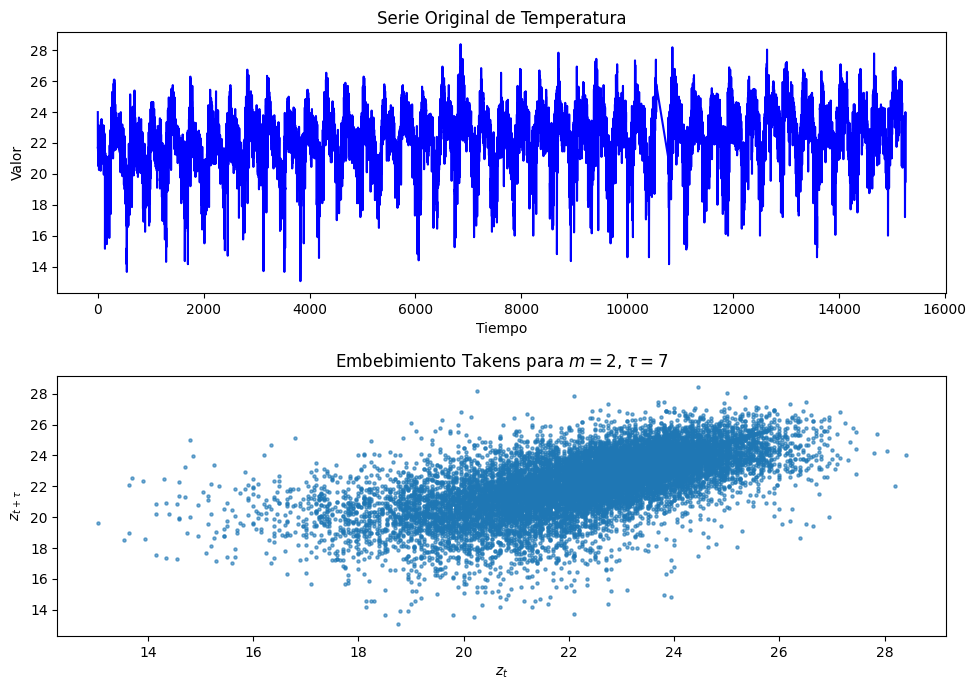

In [6]:
plot_embedding(data, time_delay=7)


###Embebimiento

In [7]:
takens = TakensEmbedding(dimension=2, time_delay=10)
sample_embedding = takens.fit_transform(data.reshape(1, -1))
sample_embedding = sample_embedding[0]

##Diagrama de persistencia
#####Después de obtener nubes de puntos, es posible construir un diagrama de persistencia (DP). Una de las formas de obtener el Dp es mediante la homología persistente de Vietoris-Rips (Una fora continua). PD muestra la distribución de agujeros, su nacimiento y muerte, para cada dimensión de homología.

In [8]:
sample_pd = VietorisRipsPersistence(homology_dimensions=(0, 1)).fit_transform([sample_embedding])[0]
plot_diagram(sample_pd)

##CARACTERÍSTICAS TOPOLÓGICAS NUMÉRICAS
#####Se dara una dimención de 3 (más propiedades topológicas) y se extraeran características Topológicas numéricas como Entropía de persistencia, Amplitudes, Curvas de Betti.


In [9]:
def extraer_caracteristicas_tda(serie, num_ventana=365, paso=30, m=30,tau=7):
    caracteristicas_lista = []
    indices = []

    takens = TakensEmbedding(dimension=m, time_delay=tau)
    homology = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
    persistence_entropy = PersistenceEntropy()
    amplitude = Amplitude(metric='wasserstein')
    betti_curve = BettiCurve()

    for i in range(0, len(serie) - num_ventana + 1, paso):
        ventana = serie[i:i + num_ventana]
        try:
            embedding = takens.fit_transform(ventana.reshape(1, -1))
            diagramas = homology.fit_transform(embedding)

            entropy_features = persistence_entropy.fit_transform(diagramas)
            amplitude_features = amplitude.fit_transform(diagramas)
            #betti_features = betti_curve.fit_transform(diagramas)

            features_ventana = []

            features_ventana.extend(entropy_features.flatten())
            features_ventana.extend(amplitude_features.flatten())

            caracteristicas_lista.append(features_ventana)
            indices.append(i + num_ventana)

        except Exception as e:
            print(f"Error en ventana {i}: {e}")
            continue

    return np.array(caracteristicas_lista), np.array(indices)